# ECS659U Neural Networks and Deep Learning Coursework
# Ilenia Maietta (220322742)

## Importing necessary libraries and tools

In [ ]:
# Import PyTorch and torchvision
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F

# Import matplotlib and numpy for graphs
import matplotlib.pyplot as plt
import numpy as np


# Read dataset and create data loaders

In [ ]:
'''
Import CIFAR dataset, define labels and load training and validation dataset
Reference for loading dataset: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
Reference for augmentation: https://pytorch.org/vision/stable/transforms.html
'''
# Define batch size
batch_size = 128

# Normalisation and std values for RGB
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Data augmentation for training set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # Randomly crop the image with padding
    transforms.RandomHorizontalFlip(), # Randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Adjust brightness, contrast, etc.
    transforms.RandomRotation(15),# Randomly rotate the image by up to 15 degrees
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)), # Randomly translate the image
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5), # Randomly apply perspective transformation
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10), # Randomly apply AutoAugment policy for CIFAR10
    transforms.ToTensor(), # Convert image to tensor
    transforms.Normalize(mean=mean, std=std), # Normalize with mean and std
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33))  # Randomly erase a portion of the image
])

# No augmentation for validation set (only normalization)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)  # Normalise with mean and std
])

# Load training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
# Load validation dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define labels for dataset classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'lorry')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


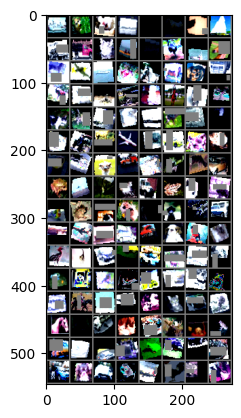

ship  deer  cat   plane car   horse cat   ship  lorry lorry cat   ship  ship  bird  ship  horse horse plane ship  deer  horse horse dog   lorry deer  plane bird  horse cat   horse cat   bird  cat   deer  cat   dog   ship  deer  deer  bird  dog   horse horse plane frog  car   deer  cat   ship  lorry bird  lorry frog  frog  deer  car   frog  plane deer  horse lorry frog  dog   deer  bird  frog  cat   dog   bird  bird  dog   car   horse plane ship  car   lorry dog   bird  cat   bird  cat   car   car   car   deer  bird  lorry dog   lorry bird  plane car   car   plane frog  car   horse bird  plane horse cat   car   bird  horse dog   lorry cat   car   deer  dog   frog  car   ship  car   lorry frog  car   car   frog  car   dog   lorry cat   plane bird  frog  cat  


In [ ]:
'''
Show images loaded from the dataset
Reference for loading dataset: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
Run if desired to see the images in the dataset
'''

def imshow(img):
    '''
    Show an image
    Input: image file to show
    Output: image
    '''
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get random training images
# dataiter = iter(trainloader)
# images, labels = next(dataiter)

# # Show images
# imshow(torchvision.utils.make_grid(images))
# # Print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Main model
Divided as such:


*   **Stem**: takes the images as inputs, extracts features from them
*   **Backbone**: made up of *K* branches, made up of an expert branch
*   **Classifier**: takes input from the last block
*   **Model**: wraps all together







## Stem
*   Takes images as inputs
*   Extracts a feature representation from them

In [ ]:
class Stem(nn.Module):
  '''
  Extract features using a Resnet-18 stem
  Input: input channels, middle channels, output channels
  Reference: Week 09 Lab
  '''
  def __init__(self, input_channels, middle_channels, output_channels):
     super(Stem,self).__init__()
     # Default parameters for convolutional layers
     kernel_size=3 # 3x3 kernel to extract features
     stride=1 # Stride=1 to maintian image size
     padding=1 # Padding=1 to maintain image size
     
     # Combine multiple layers
     self.stem = nn.Sequential(
       # First Convolutional layer transfroms input channels to middle channels
       nn.Conv2d(input_channels, middle_channels, kernel_size = kernel_size, stride = stride, padding = padding),
       nn.BatchNorm2d(middle_channels),
       nn.ReLU(inplace=True),

      # Second Convolutional layer maintains middle channels to find deeper features
       nn.Conv2d(middle_channels, middle_channels,kernel_size = kernel_size, stride = stride, padding = padding),
       nn.BatchNorm2d(middle_channels),
       nn.ReLU(inplace=True),
       nn.MaxPool2d(2), # Half the size of the image

       # Third Convolutional layer transforms middle channels to output channels
       nn.Conv2d(middle_channels, output_channels, kernel_size = kernel_size, stride = stride, padding = padding),
       nn.BatchNorm2d(output_channels),
       nn.ReLU(inplace=True),
       nn.MaxPool2d(2) # Half the size of the image
       )

  def forward(self,x):
    x = self.stem(x)
    return x

## Expert Branch

In [ ]:
class ExpertBranch(nn.Module):
  '''
  Expert branch predicting vector a with K elements from input tensor X
  Input: input channels, r, k
  '''
  def __init__(self, input_channels, k, r):
    super(ExpertBranch,self).__init__()
    # Spatially pool x
    self.pool= nn.AdaptiveAvgPool2d(1)
    #Forward through fc1, reducing by r
    self.fc1= nn.Linear(input_channels, input_channels//r)
    # Activation function ReLu
    self.relu= nn.ReLU()
    # Forward through fc2
    self.fc2= nn.Linear(input_channels//r,k)
    # Softmax activation function
    self.softmax= nn.Softmax(dim=1)

  def forward(self,x):
    # Spatially pool X
    x = self.pool(x)
    # Forward through fc1, reducing by r
    x= x.squeeze(-1).squeeze(-1)
    x = self.fc1(x)
    # Processed through non-linear activation g
    x = F.relu(x)
    # Pass through fc2
    x = self.fc2(x)
    # Forward with softmax
    x = self.softmax(x)
    return x

## Block

In [ ]:
class Block(nn.Module):
  '''
  Block has an expert branch and K convolutional layers
  Input: input channels, output channels, k, r
  '''
  def __init__(self, input_channels, output_channels, k, r):
    super(Block, self).__init__()

    # Default parameters
    kernel_size=3
    stride=1
    padding=1

    # Set parameters
    self.k= k
    self.expertBranch = ExpertBranch(input_channels, k=k, r=r)

    # Create K convolutional layers
    self.convs= nn.ModuleList([
        nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride= stride, padding=padding)
        for _ in range(k)
    ])

    # If dimensions do not match
    self.downsample = None
    if input_channels != output_channels:
        self.downsample = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(output_channels)
        )

  def forward(self,x):
    identity= x
    # Vector a from expert branch
    a = self.expertBranch(x)
    # Convolutional layers 
    conv_outputs = [conv(x) for conv in self.convs]
    stacked = torch.stack(conv_outputs, dim=1)

    # Create vector O
    a= a.view(a.size(0), self.k, 1,1,1)
    out = (a* stacked).sum(dim=1)

    # Apply downsampling for mismatched dimensions
    if self.downsample is not None:
        identity = self.downsample(identity)
        
    # Skip connection to stablise gradient descent
    out += identity
    out = F.relu(out) # activation after skip

    return out

## Backbone

In [7]:
class Backbone(nn.Module):
  '''
  N blocks
  '''
  def __init__(self, input_channels, hidden_channels, num_blocks, k, r):
    super(Backbone, self).__init__()
    self.blocks= nn.ModuleList()

    # First block takes input from stem
    self.blocks.append(Block(input_channels, hidden_channels, k=k, r=r))

    # Rest of blocks take input form previous block
    for _ in range(1, num_blocks):
      self.blocks.append(Block(hidden_channels, hidden_channels, k=k, r=r))

  def forward(self, x):
    for idx, block in enumerate(self.blocks):
      x = block(x)
    return x

## Classifier

In [8]:
class Classifier(nn.Module):
  def __init__(self, input_channels, num_classes, use_mlp):
    super(Classifier,self).__init__()
    # Default parameters
    dropout_rate=0.4
    # Spatially pool
    self.pool = nn.AdaptiveAvgPool2d(1)
    self.use_mlp= use_mlp

    if use_mlp:
      self.classifier= nn.Sequential(
          nn.Linear(input_channels, input_channels*2),
          nn.ReLU(),
          nn.Dropout(dropout_rate), # Deeper network with 3 layers
          nn.Linear(input_channels*2, input_channels),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.Linear(input_channels, num_classes)
      )
    else:
      self.classifier= nn.Linear(input_channels, num_classes)

  def forward(self, x):
    x = self.pool(x).squeeze(-1).squeeze(-1)
    out = self.classifier(x)
    return out


# Model

In [9]:
class Model(nn.Module):
  def __init__(self, input_channels, output_channels, middle_channels, hidden_channels, num_blocks, k, r, num_classes, use_mlp):
    super(Model, self).__init__()
    # Call stem
    self.stem= Stem(
      input_channels=input_channels,
      middle_channels=middle_channels,
      output_channels=output_channels
    )
    # Call backbone
    self.backbone= Backbone(
      input_channels=output_channels, 
      hidden_channels= hidden_channels, 
      num_blocks=num_blocks,
      k=k, 
      r=r)
    # Call classifier
    self.classifier= Classifier(
      input_channels=hidden_channels, 
      num_classes=num_classes,
      use_mlp= use_mlp)

  def forward(self,x):
    x= self.stem(x)
    x= self.backbone(x)
    x= self.classifier(x)
    return x

# Create the loss and optmiser


In [ ]:
model = Model(
    input_channels=3,
    output_channels=128,
    middle_channels=64,
    hidden_channels=256,
    num_blocks=10,
    k=8,
    r=4,
    num_classes=10,
    use_mlp=True
)

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model.parameters(), lr=0.05, weight_decay=3e-4, momentum=0.9, nesterov=True)
# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=5)
main_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=195)
scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer, 
    schedulers=[warmup_scheduler, main_scheduler],
    milestones=[5]
)

# Training & Testing

Batch size: 128

Epoch 1/200


Train Loss: 2.6941 | Accuracy: 13.27%
Val   Loss: 2.2296 | Accuracy: 19.41%
Saved best model.

Epoch 2/200


Train Loss: 2.2155 | Accuracy: 17.53%
Val   Loss: 2.0217 | Accuracy: 24.20%
Saved best model.

Epoch 3/200


Train Loss: 2.1321 | Accuracy: 19.82%
Val   Loss: 1.9678 | Accuracy: 27.37%
Saved best model.

Epoch 4/200


Train Loss: 2.0912 | Accuracy: 21.82%
Val   Loss: 1.9067 | Accuracy: 30.36%
Saved best model.

Epoch 5/200


Train Loss: 2.0607 | Accuracy: 23.46%
Val   Loss: 1.8807 | Accuracy: 32.89%
Saved best model.

Epoch 6/200


Train Loss: 2.0291 | Accuracy: 25.36%
Val   Loss: 1.8459 | Accuracy: 33.56%
Saved best model.

Epoch 7/200


Train Loss: 2.0069 | Accuracy: 26.88%
Val   Loss: 1.8270 | Accuracy: 37.52%
Saved best model.

Epoch 8/200


Train Loss: 1.9762 | Accuracy: 28.93%
Val   Loss: 1.7186 | Accuracy: 42.04%
Saved best model.

Epoch 9/200


Train Loss: 1.9439 | Accuracy: 31.20%
Val   Loss: 1.7102 | Accuracy: 42.77%
Saved best model.

Epoch 10/200


Train Loss: 1.9151 | Accuracy: 32.97%
Val   Loss: 1.7278 | Accuracy: 42.55%
No improvement for 1 epochs.

Epoch 11/200


Train Loss: 1.8839 | Accuracy: 35.24%
Val   Loss: 1.5500 | Accuracy: 50.11%
Saved best model.

Epoch 12/200


Train Loss: 1.8533 | Accuracy: 37.15%
Val   Loss: 1.6175 | Accuracy: 46.87%
No improvement for 1 epochs.

Epoch 13/200


Train Loss: 1.8291 | Accuracy: 38.11%
Val   Loss: 1.5359 | Accuracy: 51.40%
Saved best model.

Epoch 14/200


Train Loss: 1.7961 | Accuracy: 40.00%
Val   Loss: 1.5593 | Accuracy: 50.01%
No improvement for 1 epochs.

Epoch 15/200


Train Loss: 1.7743 | Accuracy: 41.39%
Val   Loss: 1.4574 | Accuracy: 55.48%
Saved best model.

Epoch 16/200


Train Loss: 1.7500 | Accuracy: 42.64%
Val   Loss: 1.4456 | Accuracy: 55.02%
No improvement for 1 epochs.

Epoch 17/200


Train Loss: 1.7319 | Accuracy: 43.52%
Val   Loss: 1.3926 | Accuracy: 59.08%
Saved best model.

Epoch 18/200


Train Loss: 1.7105 | Accuracy: 44.72%
Val   Loss: 1.4455 | Accuracy: 56.42%
No improvement for 1 epochs.

Epoch 19/200


Train Loss: 1.6902 | Accuracy: 45.63%
Val   Loss: 1.3860 | Accuracy: 58.73%
No improvement for 2 epochs.

Epoch 20/200


Train Loss: 1.6841 | Accuracy: 46.25%
Val   Loss: 1.3594 | Accuracy: 60.50%
Saved best model.

Epoch 21/200


Train Loss: 1.6603 | Accuracy: 47.19%
Val   Loss: 1.3517 | Accuracy: 60.93%
Saved best model.

Epoch 22/200


Train Loss: 1.6460 | Accuracy: 47.91%
Val   Loss: 1.3056 | Accuracy: 63.22%
Saved best model.

Epoch 23/200


Train Loss: 1.6325 | Accuracy: 48.66%
Val   Loss: 1.3169 | Accuracy: 62.77%
No improvement for 1 epochs.

Epoch 24/200


Train Loss: 1.6185 | Accuracy: 49.53%
Val   Loss: 1.3158 | Accuracy: 62.17%
No improvement for 2 epochs.

Epoch 25/200


Train Loss: 1.6086 | Accuracy: 49.78%
Val   Loss: 1.3322 | Accuracy: 60.87%
No improvement for 3 epochs.

Epoch 26/200


Train Loss: 1.5887 | Accuracy: 50.74%
Val   Loss: 1.2735 | Accuracy: 64.79%
Saved best model.

Epoch 27/200


Train Loss: 1.5721 | Accuracy: 51.48%
Val   Loss: 1.2208 | Accuracy: 67.69%
Saved best model.

Epoch 28/200


Train Loss: 1.5685 | Accuracy: 51.87%
Val   Loss: 1.2621 | Accuracy: 64.76%
No improvement for 1 epochs.

Epoch 29/200


Train Loss: 1.5525 | Accuracy: 52.49%
Val   Loss: 1.2203 | Accuracy: 66.66%
No improvement for 2 epochs.

Epoch 30/200


Train Loss: 1.5385 | Accuracy: 53.26%
Val   Loss: 1.2658 | Accuracy: 65.00%
No improvement for 3 epochs.

Epoch 31/200


Train Loss: 1.5287 | Accuracy: 53.72%
Val   Loss: 1.1829 | Accuracy: 68.69%
Saved best model.

Epoch 32/200


Train Loss: 1.5100 | Accuracy: 54.53%
Val   Loss: 1.1506 | Accuracy: 71.02%
Saved best model.

Epoch 33/200


Train Loss: 1.5006 | Accuracy: 54.96%
Val   Loss: 1.1636 | Accuracy: 70.68%
No improvement for 1 epochs.

Epoch 34/200


Train Loss: 1.4904 | Accuracy: 55.45%
Val   Loss: 1.1382 | Accuracy: 71.44%
Saved best model.

Epoch 35/200


Train Loss: 1.4808 | Accuracy: 55.90%
Val   Loss: 1.1342 | Accuracy: 71.36%
No improvement for 1 epochs.

Epoch 36/200


Train Loss: 1.4715 | Accuracy: 56.35%
Val   Loss: 1.0891 | Accuracy: 73.63%
Saved best model.

Epoch 37/200


Train Loss: 1.4520 | Accuracy: 57.40%
Val   Loss: 1.1091 | Accuracy: 73.07%
No improvement for 1 epochs.

Epoch 38/200


Train Loss: 1.4482 | Accuracy: 57.50%
Val   Loss: 1.0853 | Accuracy: 73.39%
No improvement for 2 epochs.

Epoch 39/200


Train Loss: 1.4438 | Accuracy: 57.79%
Val   Loss: 1.0669 | Accuracy: 75.36%
Saved best model.

Epoch 40/200


Train Loss: 1.4249 | Accuracy: 58.87%
Val   Loss: 1.0754 | Accuracy: 74.50%
No improvement for 1 epochs.

Epoch 41/200


Train Loss: 1.4226 | Accuracy: 59.19%
Val   Loss: 1.0825 | Accuracy: 74.39%
No improvement for 2 epochs.

Epoch 42/200


Train Loss: 1.4115 | Accuracy: 59.73%
Val   Loss: 1.0485 | Accuracy: 75.63%
Saved best model.

Epoch 43/200


Train Loss: 1.4013 | Accuracy: 60.09%
Val   Loss: 1.0271 | Accuracy: 76.88%
Saved best model.

Epoch 44/200


Train Loss: 1.3958 | Accuracy: 60.38%
Val   Loss: 1.0228 | Accuracy: 77.04%
Saved best model.

Epoch 45/200


Train Loss: 1.3889 | Accuracy: 60.64%
Val   Loss: 1.0370 | Accuracy: 76.32%
No improvement for 1 epochs.

Epoch 46/200


Train Loss: 1.3739 | Accuracy: 61.22%
Val   Loss: 1.0338 | Accuracy: 76.55%
No improvement for 2 epochs.

Epoch 47/200


Train Loss: 1.3752 | Accuracy: 61.29%
Val   Loss: 1.0283 | Accuracy: 76.92%
No improvement for 3 epochs.

Epoch 48/200


Train Loss: 1.3639 | Accuracy: 61.94%
Val   Loss: 1.0068 | Accuracy: 77.78%
Saved best model.

Epoch 49/200


Train Loss: 1.3526 | Accuracy: 62.63%
Val   Loss: 0.9980 | Accuracy: 78.43%
Saved best model.

Epoch 50/200


Train Loss: 1.3479 | Accuracy: 62.84%
Val   Loss: 0.9839 | Accuracy: 78.52%
Saved best model.

Epoch 51/200


Train Loss: 1.3424 | Accuracy: 63.01%
Val   Loss: 0.9791 | Accuracy: 79.00%
Saved best model.

Epoch 52/200


Train Loss: 1.3365 | Accuracy: 63.06%
Val   Loss: 0.9612 | Accuracy: 80.10%
Saved best model.

Epoch 53/200


Train Loss: 1.3293 | Accuracy: 63.70%
Val   Loss: 1.0054 | Accuracy: 77.42%
No improvement for 1 epochs.

Epoch 54/200


Train Loss: 1.3270 | Accuracy: 63.77%
Val   Loss: 0.9492 | Accuracy: 80.38%
Saved best model.

Epoch 55/200


Train Loss: 1.3204 | Accuracy: 64.03%
Val   Loss: 0.9536 | Accuracy: 80.17%
No improvement for 1 epochs.

Epoch 56/200


Train Loss: 1.3123 | Accuracy: 64.28%
Val   Loss: 0.9324 | Accuracy: 81.36%
Saved best model.

Epoch 57/200


Train Loss: 1.3027 | Accuracy: 64.76%
Val   Loss: 0.9614 | Accuracy: 80.12%
No improvement for 1 epochs.

Epoch 58/200


Train Loss: 1.2988 | Accuracy: 65.31%
Val   Loss: 0.9364 | Accuracy: 81.06%
No improvement for 2 epochs.

Epoch 59/200


Train Loss: 1.2946 | Accuracy: 65.25%
Val   Loss: 0.9312 | Accuracy: 81.02%
No improvement for 3 epochs.

Epoch 60/200


Train Loss: 1.2920 | Accuracy: 65.41%
Val   Loss: 0.9218 | Accuracy: 81.63%
Saved best model.

Epoch 61/200


Train Loss: 1.2843 | Accuracy: 65.76%
Val   Loss: 0.9521 | Accuracy: 80.13%
No improvement for 1 epochs.

Epoch 62/200


Train Loss: 1.2769 | Accuracy: 66.02%
Val   Loss: 0.9051 | Accuracy: 82.20%
Saved best model.

Epoch 63/200


Train Loss: 1.2720 | Accuracy: 66.25%
Val   Loss: 0.9199 | Accuracy: 81.67%
No improvement for 1 epochs.

Epoch 64/200


Train Loss: 1.2709 | Accuracy: 66.30%
Val   Loss: 0.8925 | Accuracy: 82.85%
Saved best model.

Epoch 65/200


Train Loss: 1.2626 | Accuracy: 66.74%
Val   Loss: 0.9231 | Accuracy: 81.58%
No improvement for 1 epochs.

Epoch 66/200


Train Loss: 1.2670 | Accuracy: 66.56%
Val   Loss: 0.8990 | Accuracy: 82.79%
No improvement for 2 epochs.

Epoch 67/200


Train Loss: 1.2571 | Accuracy: 66.99%
Val   Loss: 0.9157 | Accuracy: 81.21%
No improvement for 3 epochs.

Epoch 68/200


Train Loss: 1.2580 | Accuracy: 66.90%
Val   Loss: 0.8908 | Accuracy: 82.95%
Saved best model.

Epoch 69/200


Train Loss: 1.2453 | Accuracy: 67.71%
Val   Loss: 0.9353 | Accuracy: 80.88%
No improvement for 1 epochs.

Epoch 70/200


Train Loss: 1.2461 | Accuracy: 67.38%
Val   Loss: 0.8848 | Accuracy: 83.52%
Saved best model.

Epoch 71/200


Train Loss: 1.2386 | Accuracy: 67.76%
Val   Loss: 0.8972 | Accuracy: 82.34%
No improvement for 1 epochs.

Epoch 72/200


Train Loss: 1.2357 | Accuracy: 68.05%
Val   Loss: 0.8749 | Accuracy: 83.60%
Saved best model.

Epoch 73/200


Train Loss: 1.2346 | Accuracy: 68.08%
Val   Loss: 0.8884 | Accuracy: 83.12%
No improvement for 1 epochs.

Epoch 74/200


Train Loss: 1.2258 | Accuracy: 68.63%
Val   Loss: 0.8784 | Accuracy: 83.70%
Saved best model.

Epoch 75/200


Train Loss: 1.2283 | Accuracy: 68.10%
Val   Loss: 0.8681 | Accuracy: 83.85%
Saved best model.

Epoch 76/200


Train Loss: 1.2172 | Accuracy: 68.92%
Val   Loss: 0.8788 | Accuracy: 83.37%
No improvement for 1 epochs.

Epoch 77/200


Train Loss: 1.2159 | Accuracy: 68.76%
Val   Loss: 0.8457 | Accuracy: 85.10%
Saved best model.

Epoch 78/200


Train Loss: 1.2128 | Accuracy: 69.02%
Val   Loss: 0.8741 | Accuracy: 83.67%
No improvement for 1 epochs.

Epoch 79/200


Train Loss: 1.2117 | Accuracy: 69.05%
Val   Loss: 0.8744 | Accuracy: 83.81%
No improvement for 2 epochs.

Epoch 80/200


Train Loss: 1.2064 | Accuracy: 69.25%
Val   Loss: 0.8635 | Accuracy: 84.41%
No improvement for 3 epochs.

Epoch 81/200


Train Loss: 1.2094 | Accuracy: 69.19%
Val   Loss: 0.8558 | Accuracy: 84.35%
No improvement for 4 epochs.

Epoch 82/200


Train Loss: 1.2000 | Accuracy: 69.39%
Val   Loss: 0.8615 | Accuracy: 84.33%
No improvement for 5 epochs.

Epoch 83/200


Train Loss: 1.1998 | Accuracy: 69.57%
Val   Loss: 0.8564 | Accuracy: 84.15%
No improvement for 6 epochs.

Epoch 84/200


Train Loss: 1.1877 | Accuracy: 70.12%
Val   Loss: 0.8609 | Accuracy: 84.17%
No improvement for 7 epochs.

Epoch 85/200


Train Loss: 1.1870 | Accuracy: 70.11%
Val   Loss: 0.8690 | Accuracy: 83.92%
No improvement for 8 epochs.

Epoch 86/200


Train Loss: 1.1865 | Accuracy: 70.38%
Val   Loss: 0.8296 | Accuracy: 85.61%
Saved best model.

Epoch 87/200


Train Loss: 1.1795 | Accuracy: 70.45%
Val   Loss: 0.8232 | Accuracy: 85.64%
Saved best model.

Epoch 88/200


Train Loss: 1.1854 | Accuracy: 70.28%
Val   Loss: 0.8358 | Accuracy: 85.50%
No improvement for 1 epochs.

Epoch 89/200


Train Loss: 1.1755 | Accuracy: 70.70%
Val   Loss: 0.8284 | Accuracy: 85.63%
No improvement for 2 epochs.

Epoch 90/200


Train Loss: 1.1766 | Accuracy: 70.60%
Val   Loss: 0.8301 | Accuracy: 85.65%
Saved best model.

Epoch 91/200


Train Loss: 1.1677 | Accuracy: 71.03%
Val   Loss: 0.8317 | Accuracy: 85.43%
No improvement for 1 epochs.

Epoch 92/200


Train Loss: 1.1672 | Accuracy: 70.97%
Val   Loss: 0.8269 | Accuracy: 85.79%
Saved best model.

Epoch 93/200


Train Loss: 1.1656 | Accuracy: 71.16%
Val   Loss: 0.8139 | Accuracy: 86.62%
Saved best model.

Epoch 94/200


Train Loss: 1.1623 | Accuracy: 71.22%
Val   Loss: 0.8166 | Accuracy: 86.09%
No improvement for 1 epochs.

Epoch 95/200


Train Loss: 1.1596 | Accuracy: 71.40%
Val   Loss: 0.8192 | Accuracy: 85.85%
No improvement for 2 epochs.

Epoch 96/200


Train Loss: 1.1554 | Accuracy: 71.66%
Val   Loss: 0.8090 | Accuracy: 86.36%
No improvement for 3 epochs.

Epoch 97/200


Train Loss: 1.1526 | Accuracy: 71.75%
Val   Loss: 0.8190 | Accuracy: 85.95%
No improvement for 4 epochs.

Epoch 98/200


Train Loss: 1.1496 | Accuracy: 71.80%
Val   Loss: 0.8119 | Accuracy: 86.12%
No improvement for 5 epochs.

Epoch 99/200


Train Loss: 1.1579 | Accuracy: 71.50%
Val   Loss: 0.8083 | Accuracy: 86.76%
Saved best model.

Epoch 100/200


Train Loss: 1.1456 | Accuracy: 71.78%
Val   Loss: 0.8063 | Accuracy: 86.81%
Saved best model.

Epoch 101/200


Train Loss: 1.1479 | Accuracy: 71.88%
Val   Loss: 0.8007 | Accuracy: 86.70%
No improvement for 1 epochs.

Epoch 102/200


Train Loss: 1.1430 | Accuracy: 72.15%
Val   Loss: 0.8006 | Accuracy: 86.81%
No improvement for 2 epochs.

Epoch 103/200


Train Loss: 1.1410 | Accuracy: 72.13%
Val   Loss: 0.8157 | Accuracy: 85.80%
No improvement for 3 epochs.

Epoch 104/200


Train Loss: 1.1394 | Accuracy: 72.07%
Val   Loss: 0.8023 | Accuracy: 86.75%
No improvement for 4 epochs.

Epoch 105/200


Train Loss: 1.1372 | Accuracy: 72.52%
Val   Loss: 0.8154 | Accuracy: 86.35%
No improvement for 5 epochs.

Epoch 106/200


Train Loss: 1.1309 | Accuracy: 72.88%
Val   Loss: 0.8006 | Accuracy: 86.86%
Saved best model.

Epoch 107/200


Train Loss: 1.1290 | Accuracy: 72.61%
Val   Loss: 0.7926 | Accuracy: 87.17%
Saved best model.

Epoch 108/200


Train Loss: 1.1323 | Accuracy: 72.61%
Val   Loss: 0.8053 | Accuracy: 86.41%
No improvement for 1 epochs.

Epoch 109/200


Train Loss: 1.1233 | Accuracy: 72.93%
Val   Loss: 0.7956 | Accuracy: 86.97%
No improvement for 2 epochs.

Epoch 110/200


Train Loss: 1.1254 | Accuracy: 72.94%
Val   Loss: 0.8062 | Accuracy: 86.52%
No improvement for 3 epochs.

Epoch 111/200


Train Loss: 1.1204 | Accuracy: 72.98%
Val   Loss: 0.7892 | Accuracy: 87.29%
Saved best model.

Epoch 112/200


Train Loss: 1.1187 | Accuracy: 73.04%
Val   Loss: 0.8076 | Accuracy: 86.37%
No improvement for 1 epochs.

Epoch 113/200


Train Loss: 1.1135 | Accuracy: 73.43%
Val   Loss: 0.7751 | Accuracy: 87.88%
Saved best model.

Epoch 114/200


Train Loss: 1.1115 | Accuracy: 73.50%
Val   Loss: 0.7832 | Accuracy: 87.27%
No improvement for 1 epochs.

Epoch 115/200


Train Loss: 1.1132 | Accuracy: 73.25%
Val   Loss: 0.7981 | Accuracy: 86.96%
No improvement for 2 epochs.

Epoch 116/200


Train Loss: 1.1096 | Accuracy: 73.40%
Val   Loss: 0.7911 | Accuracy: 87.09%
No improvement for 3 epochs.

Epoch 117/200


Train Loss: 1.1108 | Accuracy: 73.69%
Val   Loss: 0.7844 | Accuracy: 87.54%
No improvement for 4 epochs.

Epoch 118/200


Train Loss: 1.1128 | Accuracy: 73.40%
Val   Loss: 0.8020 | Accuracy: 86.96%
No improvement for 5 epochs.

Epoch 119/200


Train Loss: 1.1084 | Accuracy: 73.52%
Val   Loss: 0.7897 | Accuracy: 87.22%
No improvement for 6 epochs.

Epoch 120/200


Train Loss: 1.1063 | Accuracy: 73.84%
Val   Loss: 0.7867 | Accuracy: 87.18%
No improvement for 7 epochs.

Epoch 121/200


Train Loss: 1.1052 | Accuracy: 73.75%
Val   Loss: 0.7894 | Accuracy: 87.50%
No improvement for 8 epochs.

Epoch 122/200


Train Loss: 1.0991 | Accuracy: 74.12%
Val   Loss: 0.7924 | Accuracy: 87.36%
No improvement for 9 epochs.

Epoch 123/200


Train Loss: 1.0952 | Accuracy: 74.01%
Val   Loss: 0.7656 | Accuracy: 88.42%
Saved best model.

Epoch 124/200


Train Loss: 1.0921 | Accuracy: 74.50%
Val   Loss: 0.7615 | Accuracy: 88.38%
No improvement for 1 epochs.

Epoch 125/200


Train Loss: 1.0948 | Accuracy: 74.30%
Val   Loss: 0.7792 | Accuracy: 87.60%
No improvement for 2 epochs.

Epoch 126/200


Train Loss: 1.0864 | Accuracy: 74.61%
Val   Loss: 0.7743 | Accuracy: 88.02%
No improvement for 3 epochs.

Epoch 127/200


Train Loss: 1.0911 | Accuracy: 74.35%
Val   Loss: 0.7712 | Accuracy: 88.11%
No improvement for 4 epochs.

Epoch 128/200


Train Loss: 1.0917 | Accuracy: 74.41%
Val   Loss: 0.7782 | Accuracy: 87.73%
No improvement for 5 epochs.

Epoch 129/200


Train Loss: 1.0849 | Accuracy: 74.53%
Val   Loss: 0.7616 | Accuracy: 88.61%
Saved best model.

Epoch 130/200


Train Loss: 1.0824 | Accuracy: 74.64%
Val   Loss: 0.7778 | Accuracy: 87.90%
No improvement for 1 epochs.

Epoch 131/200


Train Loss: 1.0831 | Accuracy: 74.70%
Val   Loss: 0.7705 | Accuracy: 88.01%
No improvement for 2 epochs.

Epoch 132/200


Train Loss: 1.0826 | Accuracy: 74.94%
Val   Loss: 0.7711 | Accuracy: 88.05%
No improvement for 3 epochs.

Epoch 133/200


Train Loss: 1.0784 | Accuracy: 75.13%
Val   Loss: 0.7708 | Accuracy: 88.42%
No improvement for 4 epochs.

Epoch 134/200


Train Loss: 1.0830 | Accuracy: 74.83%
Val   Loss: 0.7697 | Accuracy: 88.08%
No improvement for 5 epochs.

Epoch 135/200


Train Loss: 1.0708 | Accuracy: 75.20%
Val   Loss: 0.7590 | Accuracy: 88.43%
No improvement for 6 epochs.

Epoch 136/200


Train Loss: 1.0734 | Accuracy: 75.18%
Val   Loss: 0.7606 | Accuracy: 88.36%
No improvement for 7 epochs.

Epoch 137/200


Train Loss: 1.0684 | Accuracy: 75.49%
Val   Loss: 0.7543 | Accuracy: 88.79%
Saved best model.

Epoch 138/200


Train Loss: 1.0706 | Accuracy: 75.40%
Val   Loss: 0.7614 | Accuracy: 88.43%
No improvement for 1 epochs.

Epoch 139/200


Train Loss: 1.0698 | Accuracy: 75.40%
Val   Loss: 0.7657 | Accuracy: 88.53%
No improvement for 2 epochs.

Epoch 140/200


Train Loss: 1.0684 | Accuracy: 75.29%
Val   Loss: 0.7613 | Accuracy: 88.61%
No improvement for 3 epochs.

Epoch 141/200


Train Loss: 1.0710 | Accuracy: 75.19%
Val   Loss: 0.7468 | Accuracy: 88.85%
Saved best model.

Epoch 142/200


Train Loss: 1.0650 | Accuracy: 75.41%
Val   Loss: 0.7478 | Accuracy: 88.99%
Saved best model.

Epoch 143/200


Train Loss: 1.0661 | Accuracy: 75.45%
Val   Loss: 0.7628 | Accuracy: 88.50%
No improvement for 1 epochs.

Epoch 144/200


Train Loss: 1.0590 | Accuracy: 75.66%
Val   Loss: 0.7555 | Accuracy: 88.66%
No improvement for 2 epochs.

Epoch 145/200


Train Loss: 1.0607 | Accuracy: 75.71%
Val   Loss: 0.7488 | Accuracy: 89.03%
Saved best model.

Epoch 146/200


Train Loss: 1.0616 | Accuracy: 75.61%
Val   Loss: 0.7462 | Accuracy: 89.09%
Saved best model.

Epoch 147/200


Train Loss: 1.0569 | Accuracy: 75.76%
Val   Loss: 0.7504 | Accuracy: 88.89%
No improvement for 1 epochs.

Epoch 148/200


Train Loss: 1.0555 | Accuracy: 76.08%
Val   Loss: 0.7531 | Accuracy: 88.84%
No improvement for 2 epochs.

Epoch 149/200


Train Loss: 1.0507 | Accuracy: 76.17%
Val   Loss: 0.7492 | Accuracy: 88.95%
No improvement for 3 epochs.

Epoch 150/200


Train Loss: 1.0563 | Accuracy: 75.95%
Val   Loss: 0.7548 | Accuracy: 89.23%
Saved best model.

Epoch 151/200


Train Loss: 1.0571 | Accuracy: 75.83%
Val   Loss: 0.7611 | Accuracy: 88.51%
No improvement for 1 epochs.

Epoch 152/200


Train Loss: 1.0519 | Accuracy: 76.12%
Val   Loss: 0.7611 | Accuracy: 88.70%
No improvement for 2 epochs.

Epoch 153/200


Train Loss: 1.0489 | Accuracy: 76.12%
Val   Loss: 0.7423 | Accuracy: 89.37%
Saved best model.

Epoch 154/200


Train Loss: 1.0457 | Accuracy: 76.35%
Val   Loss: 0.7476 | Accuracy: 89.26%
No improvement for 1 epochs.

Epoch 155/200


Train Loss: 1.0460 | Accuracy: 76.34%
Val   Loss: 0.7651 | Accuracy: 88.71%
No improvement for 2 epochs.

Epoch 156/200


Train Loss: 1.0378 | Accuracy: 76.62%
Val   Loss: 0.7390 | Accuracy: 89.58%
Saved best model.

Epoch 157/200


Train Loss: 1.0400 | Accuracy: 76.64%
Val   Loss: 0.7352 | Accuracy: 89.76%
Saved best model.

Epoch 158/200


Train Loss: 1.0435 | Accuracy: 76.28%
Val   Loss: 0.7422 | Accuracy: 89.43%
No improvement for 1 epochs.

Epoch 159/200


Train Loss: 1.0438 | Accuracy: 76.37%
Val   Loss: 0.7565 | Accuracy: 88.97%
No improvement for 2 epochs.

Epoch 160/200


Train Loss: 1.0337 | Accuracy: 76.80%
Val   Loss: 0.7385 | Accuracy: 89.49%
No improvement for 3 epochs.

Epoch 161/200


Train Loss: 1.0406 | Accuracy: 76.45%
Val   Loss: 0.7465 | Accuracy: 89.09%
No improvement for 4 epochs.

Epoch 162/200


Train Loss: 1.0410 | Accuracy: 76.41%
Val   Loss: 0.7413 | Accuracy: 89.21%
No improvement for 5 epochs.

Epoch 163/200


Train Loss: 1.0350 | Accuracy: 76.84%
Val   Loss: 0.7374 | Accuracy: 89.88%
Saved best model.

Epoch 164/200


Train Loss: 1.0295 | Accuracy: 77.11%
Val   Loss: 0.7429 | Accuracy: 89.22%
No improvement for 1 epochs.

Epoch 165/200


Train Loss: 1.0296 | Accuracy: 77.09%
Val   Loss: 0.7365 | Accuracy: 89.72%
No improvement for 2 epochs.

Epoch 166/200


Train Loss: 1.0378 | Accuracy: 76.80%
Val   Loss: 0.7519 | Accuracy: 88.45%
No improvement for 3 epochs.

Epoch 167/200


Train Loss: 1.0316 | Accuracy: 76.80%
Val   Loss: 0.7411 | Accuracy: 89.54%
No improvement for 4 epochs.

Epoch 168/200


Train Loss: 1.0281 | Accuracy: 77.15%
Val   Loss: 0.7296 | Accuracy: 89.95%
Saved best model.

Epoch 169/200


Train Loss: 1.0212 | Accuracy: 77.57%
Val   Loss: 0.7409 | Accuracy: 89.24%
No improvement for 1 epochs.

Epoch 170/200


Train Loss: 1.0239 | Accuracy: 77.30%
Val   Loss: 0.7446 | Accuracy: 89.23%
No improvement for 2 epochs.

Epoch 171/200


Train Loss: 1.0293 | Accuracy: 77.14%
Val   Loss: 0.7465 | Accuracy: 88.85%
No improvement for 3 epochs.

Epoch 172/200


Train Loss: 1.0255 | Accuracy: 77.27%
Val   Loss: 0.7444 | Accuracy: 89.18%
No improvement for 4 epochs.

Epoch 173/200


Train Loss: 1.0251 | Accuracy: 77.31%
Val   Loss: 0.7489 | Accuracy: 89.24%
No improvement for 5 epochs.

Epoch 174/200


Train Loss: 1.0256 | Accuracy: 77.20%
Val   Loss: 0.7320 | Accuracy: 89.88%
No improvement for 6 epochs.

Epoch 175/200


Train Loss: 1.0224 | Accuracy: 77.57%
Val   Loss: 0.7427 | Accuracy: 89.29%
No improvement for 7 epochs.

Epoch 176/200


Train Loss: 1.0181 | Accuracy: 77.64%
Val   Loss: 0.7241 | Accuracy: 90.40%
Saved best model.

Epoch 177/200


Train Loss: 1.0221 | Accuracy: 77.41%
Val   Loss: 0.7319 | Accuracy: 90.03%
No improvement for 1 epochs.

Epoch 178/200


Train Loss: 1.0222 | Accuracy: 77.49%
Val   Loss: 0.7237 | Accuracy: 90.15%
No improvement for 2 epochs.

Epoch 179/200


Train Loss: 1.0194 | Accuracy: 77.55%
Val   Loss: 0.7381 | Accuracy: 89.46%
No improvement for 3 epochs.

Epoch 180/200


Train Loss: 1.0179 | Accuracy: 77.39%
Val   Loss: 0.7271 | Accuracy: 89.81%
No improvement for 4 epochs.

Epoch 181/200


Train Loss: 1.0114 | Accuracy: 77.87%
Val   Loss: 0.7283 | Accuracy: 90.10%
No improvement for 5 epochs.

Epoch 182/200


Train Loss: 1.0139 | Accuracy: 77.59%
Val   Loss: 0.7281 | Accuracy: 90.14%
No improvement for 6 epochs.

Epoch 183/200


Train Loss: 1.0076 | Accuracy: 78.00%
Val   Loss: 0.7329 | Accuracy: 89.69%
No improvement for 7 epochs.

Epoch 184/200


Train Loss: 1.0126 | Accuracy: 77.91%
Val   Loss: 0.7219 | Accuracy: 90.45%
Saved best model.

Epoch 185/200


Train Loss: 1.0080 | Accuracy: 78.17%
Val   Loss: 0.7422 | Accuracy: 89.38%
No improvement for 1 epochs.

Epoch 186/200


Train Loss: 1.0085 | Accuracy: 77.89%
Val   Loss: 0.7376 | Accuracy: 89.52%
No improvement for 2 epochs.

Epoch 187/200


Train Loss: 1.0044 | Accuracy: 78.13%
Val   Loss: 0.7209 | Accuracy: 90.34%
No improvement for 3 epochs.

Epoch 188/200


Train Loss: 1.0088 | Accuracy: 78.05%
Val   Loss: 0.7239 | Accuracy: 90.29%
No improvement for 4 epochs.

Epoch 189/200


Train Loss: 1.0069 | Accuracy: 78.14%
Val   Loss: 0.7357 | Accuracy: 89.48%
No improvement for 5 epochs.

Epoch 190/200


Train Loss: 1.0042 | Accuracy: 78.06%
Val   Loss: 0.7391 | Accuracy: 89.26%
No improvement for 6 epochs.

Epoch 191/200


Train Loss: 1.0037 | Accuracy: 78.30%
Val   Loss: 0.7263 | Accuracy: 89.91%
No improvement for 7 epochs.

Epoch 192/200


Train Loss: 1.0055 | Accuracy: 78.17%
Val   Loss: 0.7308 | Accuracy: 89.85%
No improvement for 8 epochs.

Epoch 193/200


Train Loss: 1.0025 | Accuracy: 78.16%
Val   Loss: 0.7293 | Accuracy: 90.06%
No improvement for 9 epochs.

Epoch 194/200


Train Loss: 0.9982 | Accuracy: 78.21%
Val   Loss: 0.7164 | Accuracy: 90.50%
Saved best model.

Epoch 195/200


Train Loss: 1.0020 | Accuracy: 78.07%
Val   Loss: 0.7548 | Accuracy: 88.92%
No improvement for 1 epochs.

Epoch 196/200


Train Loss: 1.0020 | Accuracy: 78.43%
Val   Loss: 0.7292 | Accuracy: 90.02%
No improvement for 2 epochs.

Epoch 197/200


Train Loss: 0.9999 | Accuracy: 78.28%
Val   Loss: 0.7223 | Accuracy: 90.38%
No improvement for 3 epochs.

Epoch 198/200


Train Loss: 0.9991 | Accuracy: 78.57%
Val   Loss: 0.7117 | Accuracy: 90.78%
Saved best model.

Epoch 199/200


Train Loss: 0.9972 | Accuracy: 78.39%
Val   Loss: 0.7269 | Accuracy: 89.94%
No improvement for 1 epochs.

Epoch 200/200


Train Loss: 0.9956 | Accuracy: 78.54%
Val   Loss: 0.7196 | Accuracy: 90.29%
No improvement for 2 epochs.

Training Complete

Final Averages Over All Epochs
Average Train Loss: 1.2533
Average Train Accuracy: 66.61%
Average Val   Loss: 0.9381
Average Val   Accuracy: 80.24%
Plots saved: loss_curve.png and accuracy_curve.png


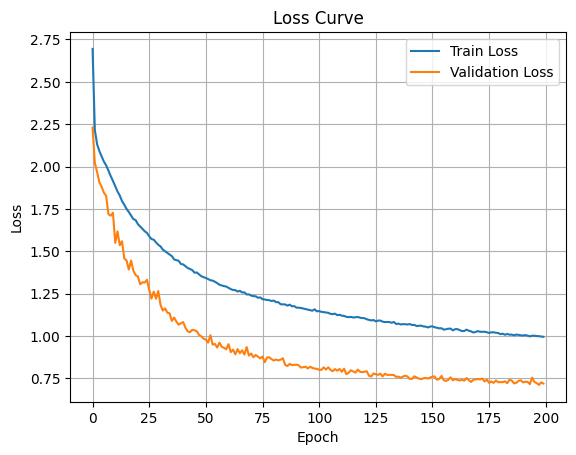

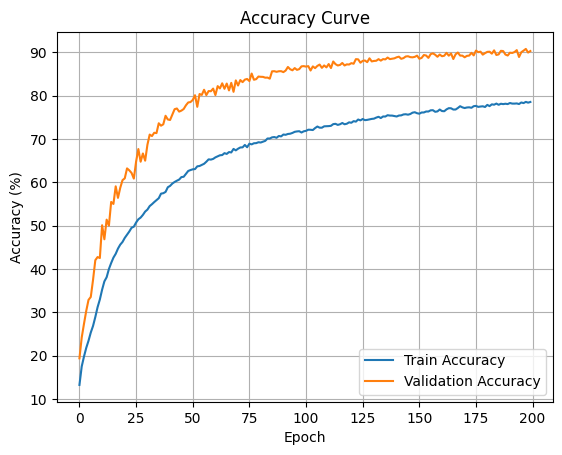

In [11]:
# Set up device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Save model
model.to(device)

# Log training 
train_losses, val_losses = [], []
train_accuracies = []
val_accuracies = []

batch_size=128
print('Batch size:', batch_size)

# Training and Validation Loops 
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100 * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total = 0
    correct = 0
    loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return loss / len(loader), 100 * correct / total

# Main Loop 
patience = 20 # Number of epochs to wait for improvement
early_stop_counter = 0 # Counter for early stopping
epochs = 200
best_acc = 0.0

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    train_loss, train_acc = train(model, trainloader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, testloader, criterion, device)


    # Log metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        early_stop_counter=0
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model.")
    else:
        early_stop_counter += 1
        print(f"No improvement for {early_stop_counter} epochs.")

    if early_stop_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break
print("\nTraining Complete")

# Print Final Averages 
avg_train_loss = sum(train_losses) / len(train_losses)
avg_val_loss = sum(val_losses) / len(val_losses)
avg_train_acc = sum(train_accuracies) / len(train_accuracies)
avg_val_acc = sum(val_accuracies) / len(val_accuracies)

print("\nFinal Averages Over All Epochs")
print(f"Average Train Loss: {avg_train_loss:.4f}")
print(f"Average Train Accuracy: {avg_train_acc:.2f}%")
print(f"Average Val   Loss: {avg_val_loss:.4f}")
print(f"Average Val   Accuracy: {avg_val_acc:.2f}%")


# Plot results

# Plot Loss
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig("loss_curve.png")

# Plot Accuracy
plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.savefig("accuracy_curve.png")

print("Plots saved: loss_curve.png and accuracy_curve.png")
